In [6]:
import numpy as np
import matplotlib.pyplot as plt
from functions.rotational_broadening_kernel import rotational_broadening_kernel
from functions.functions import vel_array
import os

# Rotational Broadening Kernel Function
The rotational broadening kernel function generates a kernel for a given orbital phase and velocity space. The use of the kernel is to convolve it with a spectrum to account for not only rotational broadening, but also the "phase" of the exoplanet.

The kernel function first creates a reference kernel. This is a full $\sqrt{v_{eq} - x^2}$ curve in velocity space that is normalised, where $v_{eq}$ is the "*equatorial velocity*" or the radial velocity associated with the spin of the planet. Each kernel is then normalised relative to the full kernel. This ensures that the brightest point is when the kernel is the largest i.e the exoplanet just before and just after the secondary eclipse.

The velocity array function creates a velocity array with sampling 
$$dv = \frac{c}{R}$$
for a given resolution $R$ over a given range i.e x = vel_array(range, resolution). This is important, as the kernel is attempting to shift the spectrum due to the doppler effect given by the rotational velocity, so the velocity array must be sampled in the same resolution such that the spectrum is shifted in the desired way.

Reference kernel generated
Kernels generated for all orbital phases given


(2.1, 2.102)

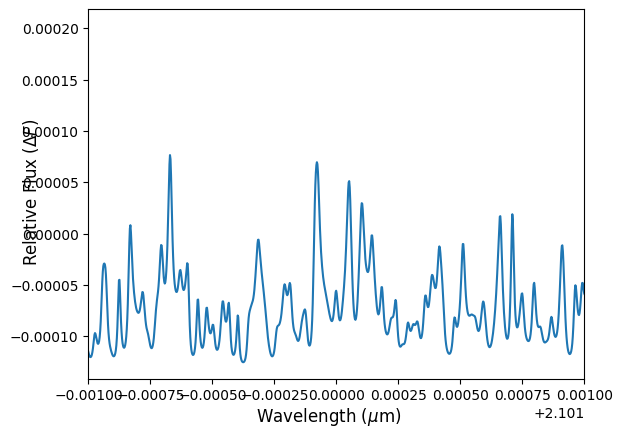

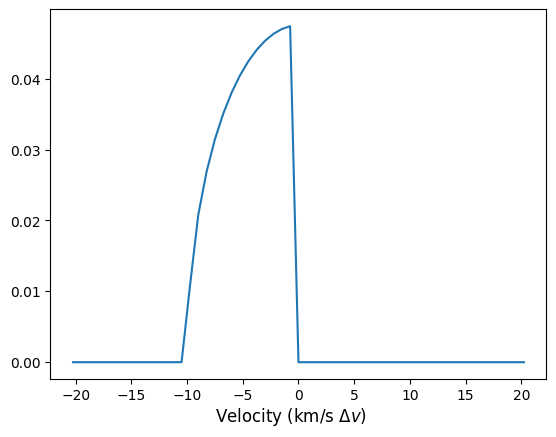

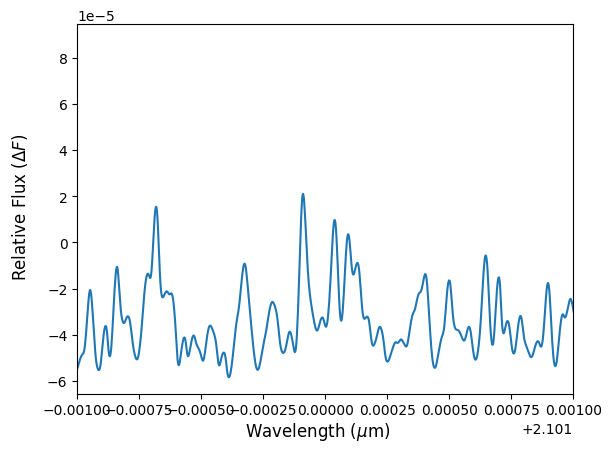

In [7]:
wasp121b_spectrum = np.load(
    os.path.join("data", "wasp121b.npz")
)  # relative flux (normalised) and wavelength in microns

wl = wasp121b_spectrum["wl"]
flux = wasp121b_spectrum["flux"]
flux -= np.mean(flux)

fig, ax = plt.subplots()
ax.plot(wl, flux)
fig.supxlabel(r'Wavelength ($\mu$m)')
fig.supylabel(r'Relative Flux ($\Delta F$)')

ax.set_xlim(2.1,2.102)

op = 0.25
Kp = 100
veq = 10

resolution = 400000
x = vel_array(20, resolution)
kernel = rotational_broadening_kernel(x, op, veq)


fig, ax = plt.subplots()
ax.plot(x, kernel)
fig.supxlabel(r'Velocity (km/s $\Delta v$)')

"""
Convolution reduces flux and shifts spectrum slightly
"""
convolved_flux = np.convolve(flux, kernel, 'same')

fig, ax = plt.subplots()
ax.plot(wl, convolved_flux)
fig.supxlabel(r'Wavelength ($\mu$m)')
fig.supylabel(r'Relative Flux ($\Delta F$)')
ax.set_xlim(2.1,2.102)

# Creating a spectrum over time
By using the time_dependent_spectrum function we can create a spectrum from the WASP-121b simulated data that evolves over time. This function has an additional kernel parameter that convolves the spectrum with the kernel given. These can be time dependent kernels, given by an array ordered linearly in time, or a singular kernel that convolves the whole spectrum at every point in time.

Unconvolved spectrum generated
Reference kernel generated
Kernels generated for all orbital phases given
Convolved spectrum generated


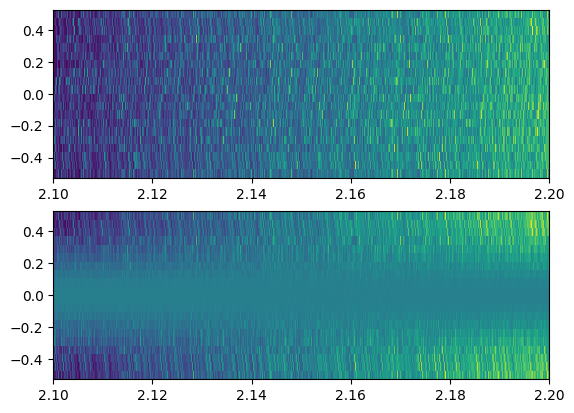

In [9]:
from functions.functions import time_dependent_spectrum

# Create points over entire orbital phase
op = np.linspace(-0.5, 0.5, 20)

# Create spectrum with no kernel
unconvolved_spectrum = time_dependent_spectrum(wl=wl, flux=flux, kp=Kp, op=op)

# Generate time dependent kernels
kernels = rotational_broadening_kernel(x, op, veq)

# Create spectrum with kernel
convolved_spectrum = time_dependent_spectrum(wl=wl, flux=flux, kp=Kp, op=op, kernel=kernels)

fig, ax = plt.subplots(2)
ax[0].pcolormesh(wl, op ,unconvolved_spectrum)
ax[1].pcolormesh(wl, op ,convolved_spectrum)

As is clear, the spectrum follows a sinusoidal as the bulk velocity obeys
$$v_p = K_p\sin(2\pi\phi)$$
which is why $K_p$ is one of the parameters in the time dependent spectrum function. After the convolution this assumption is broken as the kernel shifts the spectrum by different amounts, in different directions, at different times. We can see this adding the bulk velocity to the kernel and plot it directly to see this effect.

Reference kernel generated
Kernels generated for all orbital phases given


Text(0.02, 0.5, 'Orbital Phase ($\\phi$)')

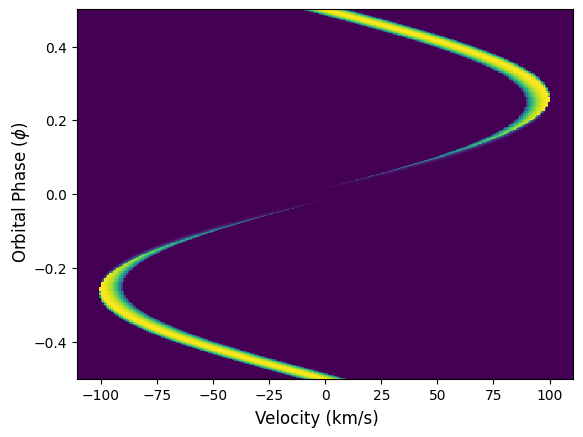

In [12]:
from functions.direct_kernel_plot import kernel_to_cc

x = vel_array(110, resolution)
op = np.linspace(-0.5, 0.5, 1000)
kernels = rotational_broadening_kernel(x, op, veq)
kernels_and_bulk = kernel_to_cc(kernels, op, Kp, resolution)

fig, ax = plt.subplots()
ax.pcolormesh(x, op, kernels_and_bulk)
fig.supxlabel(r"Velocity (km/s)")
fig.supylabel(r"Orbital Phase ($\phi$)")

# Conclusion
Here we can see during the transit at 0 orbital phase, the sinusoidal shape seems to be broken by the rotational broadening after the signal goes dark. This may imply that to analyse the $K_p$ of a planet properly traditionally methods cannot be imposed as they assert a Keplerian shape.